In [1]:
import os
import mne
from mne import cov
from mne.preprocessing import ICA
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

from mne.channels import make_dig_montage

from mne.preprocessing import ICA, create_eog_epochs, create_ecg_epochs,corrmap

In [2]:
data_path = 'C:/Users/pkhan/Desktop/Kaiserslautern/Thesis/Data/AuditoryFif'
name = 'p20_4804_auditory.fif' 
raw = mne.io.read_raw_fif(os.path.join(data_path, name), preload=True)

print(raw)
print(raw.info)

Opening raw data file C:/Users/pkhan/Desktop/Kaiserslautern/Thesis/Data/AuditoryFif\p20_4804_auditory.fif...
    Range : 43875 ... 962909 =     43.875 ...   962.909 secs
Ready.


C:\Users\pkhan\AppData\Local\Temp\ipykernel_23764\3676891805.py:3: RuntimeWarning: This filename (C:/Users/pkhan/Desktop/Kaiserslautern/Thesis/Data/AuditoryFif\p20_4804_auditory.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(os.path.join(data_path, name), preload=True)


Reading 0 ... 919034  =      0.000 ...   919.034 secs...
<Raw | p20_4804_auditory.fif, 193 x 919035 (919.0 s), ~1.32 GB, data loaded>
<Info | 19 non-empty values
 acq_pars: ACQch001 111001 ACQch002 111002 ACQch003 111003 ACQch004 111004 ...
 bads: []
 ch_names: MEG 001, MEG 002, MEG 003, MEG 004, MEG 005, MEG 006, MEG 007, ...
 chs: 122 Gradiometers, 7 Stimulus, 64 EEG
 custom_ref_applied: False
 description: These data were measured with Neuromag-122
 dev_head_t: MEG device -> head transform
 dig: 86 items (3 Cardinal, 4 HPI, 79 Extra)
 events: 1 item (list)
 experimenter: eeg
 highpass: 0.0 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 330.0 Hz
 meas_date: 2024-12-19 16:44:48 UTC
 meas_id: 4 items (dict)
 nchan: 193
 proj_id: 1 item (ndarray)
 proj_name: andre
 projs: []
 sfreq: 1000.0 Hz
 subject_info: 3 items (dict)
>


Effective window size : 2.048 (s)
Plotting power spectral density (dB=True).


C:\Users\pkhan\AppData\Local\Temp\ipykernel_23764\2549591713.py:1: UserWarning: Zero value in spectrum for channels MEG 001, MEG 006, MEG 026, MEG 027, MEG 079, MEG 091
  spectrum = raw.compute_psd()
C:\Users\pkhan\AppData\Local\Temp\ipykernel_23764\2549591713.py:2: UserWarning: Infinite value in PSD for channels MEG 001, MEG 006, MEG 026, MEG 027, MEG 079, MEG 091.
These channels might be dead.
  spectrum.plot(average=True, picks="data", exclude="bads", amplitude=False)
c:\Users\pkhan\anaconda3\envs\mne\Lib\site-packages\mne\viz\utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


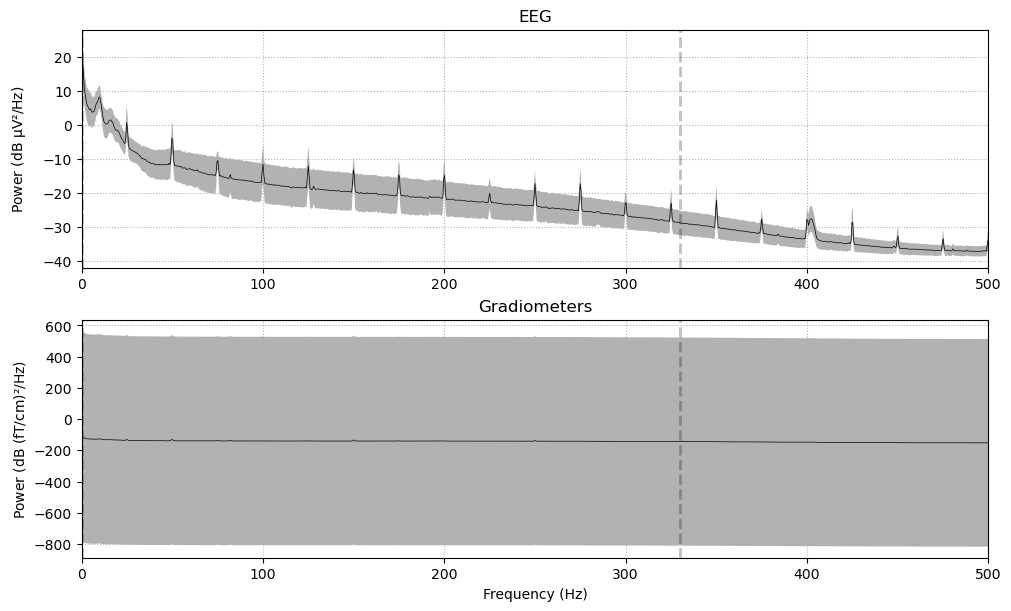

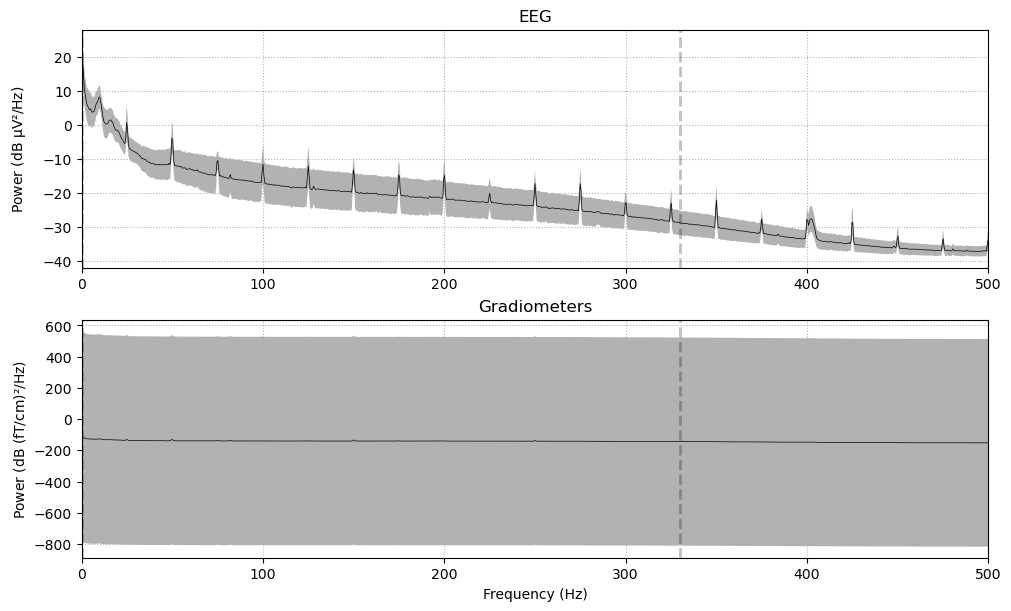

In [3]:
spectrum = raw.compute_psd()
spectrum.plot(average=True, picks="data", exclude="bads", amplitude=False)

In [4]:
# Change EEG064 to ECG
raw.set_channel_types({'EEG 064': 'ecg'})


<Raw | p20_4804_auditory.fif, 193 x 919035 (919.0 s), ~1.32 GB, data loaded>

151 events found on stim channel STI 001
Event IDs: [5]
91 events found on stim channel STI 002
Event IDs: [5]
1 event found on stim channel STI 003
Event IDs: [5]
151 events found on stim channel STI 004
Event IDs: [5]
15 events found on stim channel STI 005
Event IDs: [5]
105 events found on stim channel STI 006
Event IDs: [5]
unique ID's found:  [ 1  2  7  8 16 32 41 42 43]
[[ 56482      0      8]
 [ 56551      0      2]
 [ 57551      0      1]
 [ 58640      0     41]
 [ 67106      0      8]
 [ 68167      0      1]
 [ 69283      0     42]
 [ 81424      0      8]
 [ 82499      0      1]
 [ 83559      0     43]
 [ 89259      0     32]
 [ 89315      0      2]
 [ 90315      0      1]
 [ 91441      0     41]
 [100105      0      8]
 [101164      0      1]
 [102271      0     42]
 [112945      0      8]
 [114013      0      1]
 [115101      0     43]
 [119610      0     16]
 [119680      0      2]
 [120680      0      1]
 [121790      0     41]
 [127821      0      8]
 [128896      0     

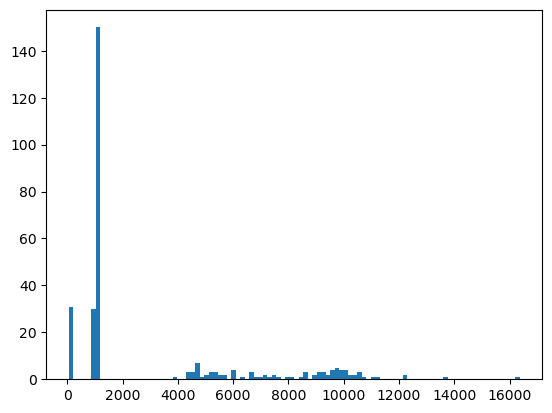

In [5]:
"""Checking trigger lines
17 Sept 2024
"""

from functools import reduce
from itertools import combinations

# %%
def find_6ch_binary_events(raw):
    adjust_timeline_by_msec = 0
    shortest_event = 0.001
    min_duration = 0.003

    # Binary Coding of 6 Stim Channels in Biomagenetism Lab Heidelberg
    # prepare arrays
    events = np.ndarray(shape=(0, 3), dtype=np.int32)
    evs = list()
    evs_tol = list()

    # Find events for each stim channel, append sample values to list
    evs.append(
        mne.find_events(
            raw,
            min_duration=min_duration,
            shortest_event=shortest_event,
            stim_channel=["STI 001"],
        )[:, 0]
    )
    evs.append(
        mne.find_events(
            raw,
            min_duration=min_duration,
            shortest_event=shortest_event,
            stim_channel=["STI 002"],
        )[:, 0]
    )
    evs.append(
        mne.find_events(
            raw,
            min_duration=min_duration,
            shortest_event=shortest_event,
            stim_channel=["STI 003"],
        )[:, 0]
    )
    evs.append(
        mne.find_events(
            raw,
            min_duration=min_duration,
            shortest_event=shortest_event,
            stim_channel=["STI 004"],
        )[:, 0]
    )
    evs.append(
        mne.find_events(
            raw,
            min_duration=min_duration,
            shortest_event=shortest_event,
            stim_channel=["STI 005"],
        )[:, 0]
    )
    evs.append(
        mne.find_events(
            raw,
            min_duration=min_duration,
            shortest_event=shortest_event,
            stim_channel=["STI 006"],
        )[:, 0]
    )

    for i in evs:
        # delete events in each channel,
        # which are too close too each other (1ms)
        too_close = np.where(np.diff(i) <= 1)
        if np.size(too_close) >= 1:
            print(
                f"Two close events (1ms) at samples "
                f"{i[too_close] + raw.first_samp}, first deleted"
            )
            i = np.delete(i, too_close, 0)
            evs[evs.index(i)] = i

        # add tolerance to each value
        i_tol = np.ndarray(shape=(0, 1), dtype=np.int32)
        for t in i:
            i_tol = np.append(i_tol, t - 1)
            i_tol = np.append(i_tol, t)
            i_tol = np.append(i_tol, t + 1)

        evs_tol.append(i_tol)

    # Get events from combinated Stim-Channels
    equals = reduce(
        np.intersect1d,
        (evs_tol[0], evs_tol[1], evs_tol[2], evs_tol[3], evs_tol[4], evs_tol[5]),
    )
    # elimnate duplicated events
    too_close = np.where(np.diff(equals) <= 1)
    if np.size(too_close) >= 1:
        equals = np.delete(equals, too_close, 0)
        equals -= 1  # correction, because of shift with deletion

    for q in equals:
        if (
            q not in events[:, 0]
            and q not in events[:, 0] + 1
            and q not in events[:, 0] - 1
        ):
            events = np.append(events, [[q, 0, 63]], axis=0)

    for a, b, c, d, e in combinations(range(6), 5):
        equals = reduce(
            np.intersect1d, (evs_tol[a], evs_tol[b], evs_tol[c], evs_tol[d], evs_tol[e])
        )
        too_close = np.where(np.diff(equals) <= 1)
        if np.size(too_close) >= 1:
            equals = np.delete(equals, too_close, 0)
            equals -= 1

        for q in equals:
            if (
                q not in events[:, 0]
                and q not in events[:, 0] + 1
                and q not in events[:, 0] - 1
            ):
                events = np.append(
                    events,
                    [[q, 0, int(2**a + 2**b + 2**c + 2**d + 2**e)]],
                    axis=0,
                )

    for a, b, c, d in combinations(range(6), 4):
        equals = reduce(
            np.intersect1d, (evs_tol[a], evs_tol[b], evs_tol[c], evs_tol[d])
        )
        too_close = np.where(np.diff(equals) <= 1)
        if np.size(too_close) >= 1:
            equals = np.delete(equals, too_close, 0)
            equals -= 1

        for q in equals:
            if (
                q not in events[:, 0]
                and q not in events[:, 0] + 1
                and q not in events[:, 0] - 1
            ):
                events = np.append(
                    events, [[q, 0, int(2**a + 2**b + 2**c + 2**d)]], axis=0
                )

    for a, b, c in combinations(range(6), 3):
        equals = reduce(np.intersect1d, (evs_tol[a], evs_tol[b], evs_tol[c]))
        too_close = np.where(np.diff(equals) <= 1)
        if np.size(too_close) >= 1:
            equals = np.delete(equals, too_close, 0)
            equals -= 1

        for q in equals:
            if (
                q not in events[:, 0]
                and q not in events[:, 0] + 1
                and q not in events[:, 0] - 1
            ):
                events = np.append(events, [[q, 0, int(2**a + 2**b + 2**c)]], axis=0)

    for a, b in combinations(range(6), 2):
        equals = np.intersect1d(evs_tol[a], evs_tol[b])
        too_close = np.where(np.diff(equals) <= 1)
        if np.size(too_close) >= 1:
            equals = np.delete(equals, too_close, 0)
            equals -= 1

        for q in equals:
            if (
                q not in events[:, 0]
                and q not in events[:, 0] + 1
                and q not in events[:, 0] - 1
            ):
                events = np.append(events, [[q, 0, int(2**a + 2**b)]], axis=0)

    # Get single-channel events
    for i in range(6):
        for e in evs[i]:
            if (
                e not in events[:, 0]
                and e not in events[:, 0] + 1
                and e not in events[:, 0] - 1
            ):
                events = np.append(events, [[e, 0, 2**i]], axis=0)

    # sort only along samples(column 0)
    events = events[events[:, 0].argsort()]

    # apply latency correction
    events[:, 0] = [
        ts + np.round(adjust_timeline_by_msec * 10**-3 * raw.info["sfreq"])
        for ts in events[:, 0]
    ]

    ids = np.unique(events[:, 2])
    print("unique ID's found: ", ids)
    return events


# %%
events = find_6ch_binary_events(raw)
print(events)
#%%
# compute the time between events
diffT = np.diff(events[:, 0])
#%%
# please plot a histogram of the time differences
import matplotlib.pyplot as plt
plt.hist(diffT, bins=100)
plt.show()


In [6]:
raw.plot(events=events, start=0, duration=10, n_channels=64)

Using qt as 2D backend.


In [7]:
#raw.info['bads'] = ['MEG 007', 'MEG 008', 'MEG 027', 'MEG 036', 'MEG 068', 'MEG 079', 'MEG 091', 'MEG 103']  

for p02_xxxx_auditory.fif: Channels marked as bad:
['MEG 007', 'MEG 008', 'MEG 027', 'MEG 036', 'MEG 068', 'MEG 079', 'MEG 091', 'MEG 103']

for p20_xxxx_auditory.fif : Channels marked as bad:
['MEG 006', 'MEG 027', 'MEG 026', 'MEG 068', 'MEG 079', 'MEG 089', 'MEG 091', 'MEG 103']

C:\Users\pkhan\AppData\Local\Temp\ipykernel_23764\1540298109.py:13: RuntimeWarning: event 7 missing from event_id will be ignored
  fig = mne.viz.plot_events(events, raw.info["sfreq"], raw.first_samp, event_id=event_dict)


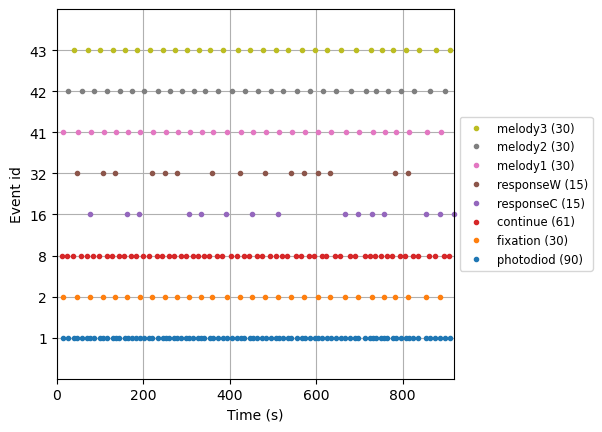

In [8]:
# This is a dictionary to define the meaning of each event code
event_dict = {  
    "continue" :8,
    "fixation": 2,
    "photodiod": 1,
    "melody1": 41,
    "melody2": 42,
    "melody3": 43,
    "responseC": 16,
    "responseW": 32,
}

fig = mne.viz.plot_events(events, raw.info["sfreq"], raw.first_samp, event_id=event_dict)

In [9]:
raw.plot(
    events=events,
    start=0,
    event_color={8: "red", 2: "orange", 1: "blue", 41: "gray", 42: "purple", 43: "green", 16: "pink", 32: "yellow", 7: "black"},
    event_id=event_dict,
)


In [10]:
print(raw.info['dig'])

[<DigPoint |        LPA : (-77.6, -0.0, 0.0) mm     : head frame>, <DigPoint |     Nasion : (0.0, 103.0, 0.0) mm      : head frame>, <DigPoint |        RPA : (75.3, 0.0, -0.0) mm      : head frame>, <DigPoint |     HPI #1 : (82.1, -17.0, 48.0) mm    : head frame>, <DigPoint |     HPI #2 : (40.9, 113.7, 70.9) mm    : head frame>, <DigPoint |     HPI #3 : (-82.2, -17.7, 52.2) mm   : head frame>, <DigPoint |     HPI #4 : (-43.9, 108.3, 69.7) mm   : head frame>, <DigPoint |   Extra #1 : (0.1, 68.1, 132.3) mm     : head frame>, <DigPoint |   Extra #2 : (32.8, 52.0, 132.8) mm    : head frame>, <DigPoint |   Extra #3 : (30.8, 18.1, 145.7) mm    : head frame>, <DigPoint |   Extra #4 : (4.0, 0.3, 150.9) mm      : head frame>, <DigPoint |   Extra #5 : (-25.0, 17.6, 150.0) mm   : head frame>, <DigPoint |   Extra #6 : (-30.9, 49.1, 135.0) mm   : head frame>, <DigPoint |   Extra #7 : (18.5, 94.5, 113.8) mm    : head frame>, <DigPoint |   Extra #8 : (49.2, 71.9, 113.1) mm    : head frame>, <DigPoint

C:\Users\pkhan\AppData\Local\Temp\ipykernel_23764\2688909945.py:49: RuntimeWarning: Not setting position of 1 ecg channel found in montage:
['EEG 064']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage(montage)


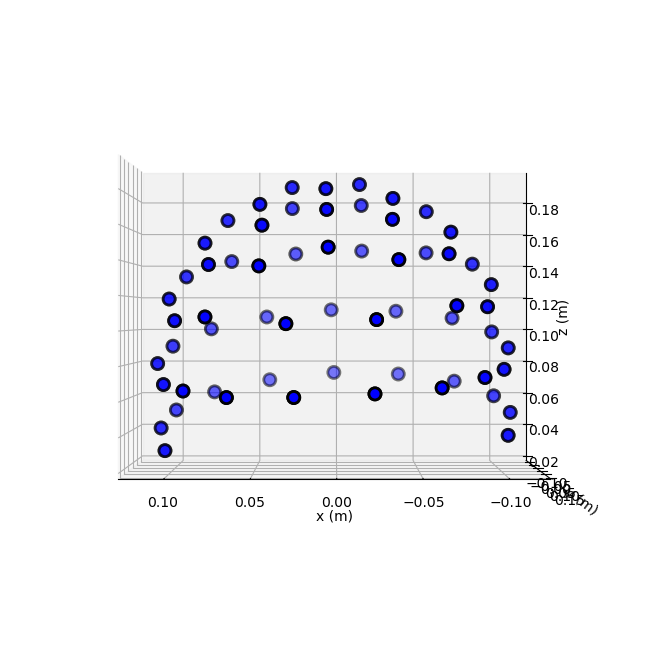

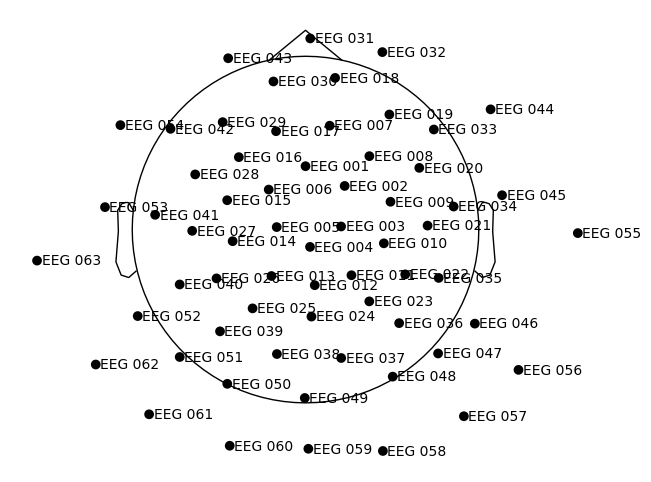

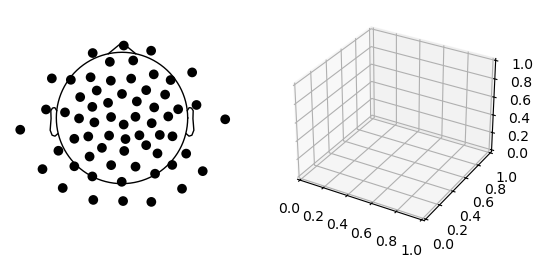

In [11]:
import mne
from mne.channels import make_dig_montage

raw.info['dig'] # to check index of LPA and RPA

channel_no=64
eeg_dig_start=7
eeg_dig_end= 71
hpi_dig_start=3
hpi_coils=4


# get the cardinal points
digi = raw.info['dig']

# extract eeg sensors positions
eeg_dig_pos = []
for i in range(eeg_dig_start, eeg_dig_end):
    loc = raw.info['dig'][i].get('r')
    eeg_dig_pos.append(loc)

# Extract HPI coil positions
hpi_pos = []
for j in range(hpi_dig_start, eeg_dig_start):
    coil_pos = raw.info['dig'][j].get('r')
    hpi_pos.append(coil_pos)

if len(hpi_pos) != hpi_coils:
    print('Error....check the HPI coil definition')
    exit()

# Extra extra digitization positions
hsp = []
for k in range(eeg_dig_start, len(digi)):
    extra_dig = raw.info['dig'][k].get('r')
    hsp.append(extra_dig)

# zip up the eeg sensor position along with their names
eeg_chs = raw.info['ch_names'][-channel_no:]
eeg_ch_pos = dict(zip(eeg_chs, eeg_dig_pos))


# create the EEG montage
montage = make_dig_montage(ch_pos=eeg_ch_pos, nasion=raw.info['dig'][1].get('r'),
                           lpa=raw.info['dig'][0].get('r'), rpa=raw.info['dig'][2].get('r'),
                           hsp=hsp, hpi=hpi_pos) 

# apply the montage
raw.set_montage(montage)


raw.plot_sensors(ch_type='grad', kind='3d') # default kind='topomap'
raw.plot_sensors(ch_type='eeg', show_names=True)

fig = plt.figure()
ax2d = fig.add_subplot(121)
ax3d = fig.add_subplot(122, projection='3d')
raw.plot_sensors(ch_type='eeg',axes=ax2d)
raw.plot_sensors(ch_type='eeg',axes=ax3d, kind='3d')
ax3d.view_init(azim=70, elev=15) # set view angle



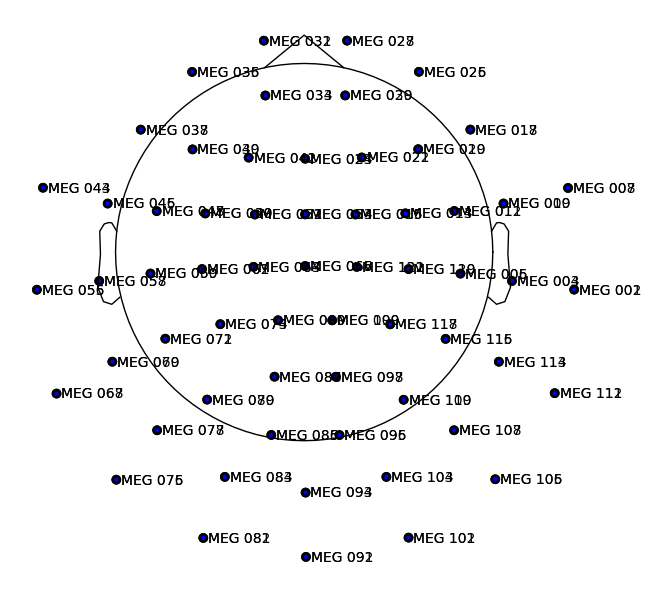

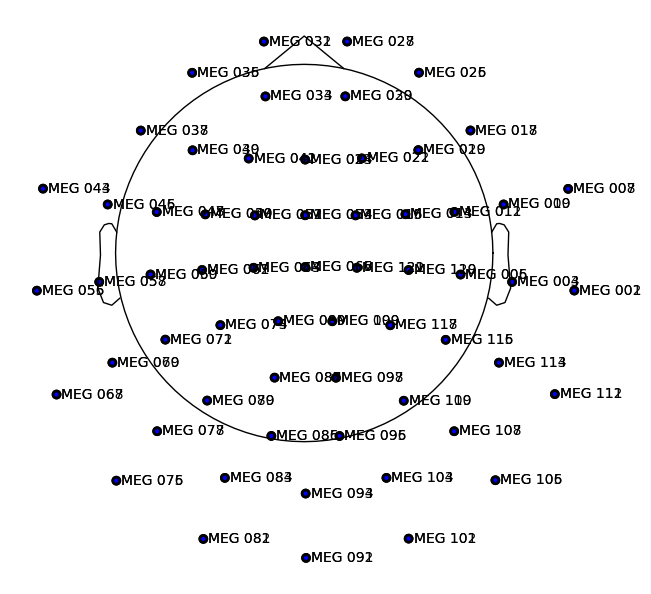

In [12]:
raw.plot_sensors(show_names=True)

In [13]:
ssp_projectors = raw.info["projs"]
raw.del_proj()



<Raw | p20_4804_auditory.fif, 193 x 919035 (919.0 s), ~1.32 GB, data loaded>

Effective window size : 2.048 (s)
Plotting power spectral density (dB=True).


C:\Users\pkhan\AppData\Local\Temp\ipykernel_23764\3224589103.py:1: UserWarning: Zero value in spectrum for channels MEG 001, MEG 006, MEG 026, MEG 027, MEG 079, MEG 091
  spectrum = raw.compute_psd(tmax=np.inf, fmax=250)
C:\Users\pkhan\AppData\Local\Temp\ipykernel_23764\3224589103.py:2: UserWarning: Infinite value in PSD for channels MEG 001, MEG 006, MEG 026, MEG 027, MEG 079, MEG 091.
These channels might be dead.
  fig = spectrum.plot(average=True, picks="data", exclude="bads", amplitude=False)
c:\Users\pkhan\anaconda3\envs\mne\Lib\site-packages\mne\viz\utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


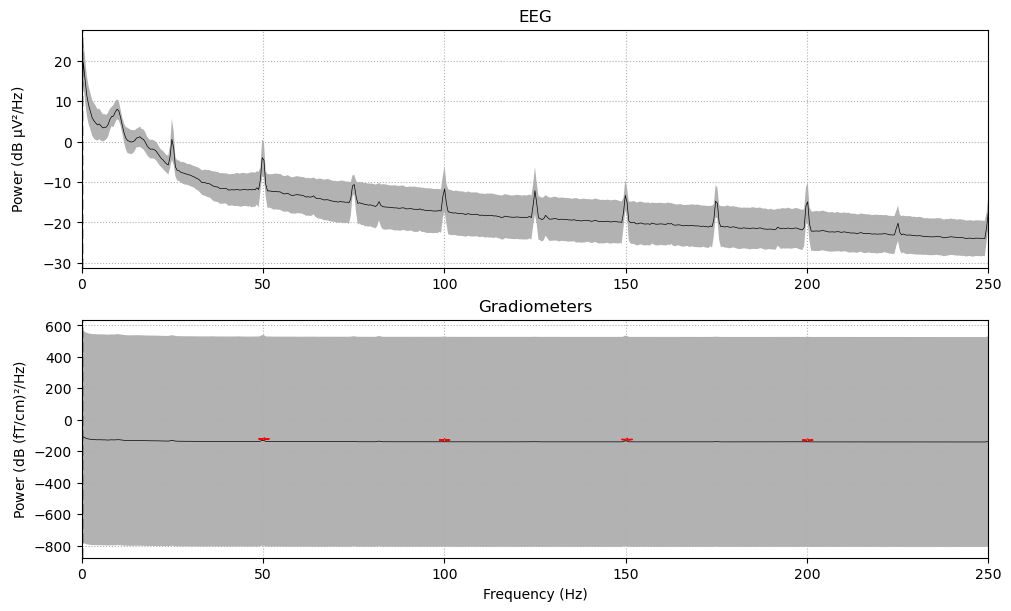

Channels marked as bad:
none
Channels marked as bad:
none


In [14]:
spectrum = raw.compute_psd(tmax=np.inf, fmax=250)
fig = spectrum.plot(average=True, picks="data", exclude="bads", amplitude=False)

for ax in fig.axes[1:]:
    freqs = ax.lines[-1].get_xdata()
    psds = ax.lines[-1].get_ydata()
    for freq in (50, 100, 150, 200):  # Adjusted for Germany
        idx = np.searchsorted(freqs, freq)
        ax.arrow(
            x=freqs[idx],
            y=psds[idx] + 18,
            dx=0,
            dy=-12,
            color="red",
            width=0.1,
            head_width=3,
            length_includes_head=True,
        )



**The code was adjusted to Germany's power frequency**